In [ ]:
sh = """
#!/bin/bash

# download and unzip dataset
wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
unzip tiny-imagenet-200.zip

current="$(pwd)/tiny-imagenet-200"

# training data
cd $current/train
for DIR in $(ls); do
   cd $DIR
   rm *.txt
   mv images/* .
   rm -r images
   cd ..
done

# validation data
cd $current/val
annotate_file="val_annotations.txt"
length=$(cat $annotate_file | wc -l)
for i in $(seq 1 $length); do
    # fetch i th line
    line=$(sed -n ${i}p $annotate_file)
    # get file name and directory name
    file=$(echo $line | cut -f1 -d" " )
    directory=$(echo $line | cut -f2 -d" ")
    mkdir -p $directory
    mv images/$file $directory
done
rm -r images
echo "done"
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-imagenet-200/val/images/val_1598.JPEG  
  inflating: tiny-ima

In [ ]:
!pip install tensorflow==1.14.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 53 kB/s 
     |████████████████████████████████| 3.1 MB 58.0 MB/s 
     |████████████████████████████████| 488 kB 77.0 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220929150707
    Uninstalling tensorflow-2.8.2+zzzcolab20220929150707:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220929150707
ERROR: pip's dependency resolver does not currently ta

In [ ]:
import tensorflow
print(tensorflow.__version__)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [ ]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container

from tensorflow.python.keras.engine.network import Network
from tensorflow.keras.layers import *
from tensorflow.keras import backend
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [ ]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c)
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    """
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        print("2")
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)
    """
    # Return train and test data as numpy arrays.
    #return np.array(X_train), np.array(X_test)
    return np.array(X_train)

In [ ]:
# Load dataset.
#X_train_orig, X_test_orig = load_dataset_small()
X_train_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [ ]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S1: secret image1
input_S1 = X_train[0:X_train.shape[0] // 4]
# S2: secret image2
input_S2 = X_train[X_train.shape[0] // 4 : 2*(X_train.shape[0] // 4)]
# S3: secret image3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]


# C: cover image
input_C = X_train[3*(X_train.shape[0] // 4):]

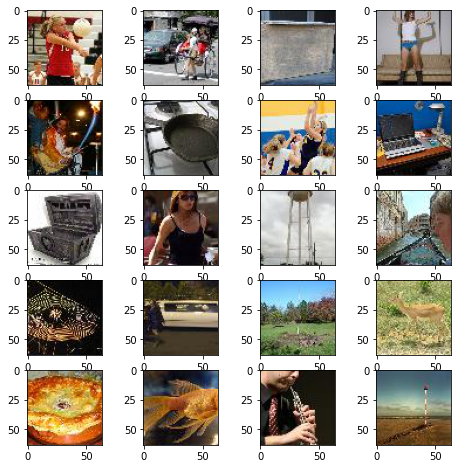

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [ ]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return s_true-s_pred

    print(s_true.shape, s_pred.shape)
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    print(y_true.shape, y_pred.shape)
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    #s_loss = rev_loss(s_true, s_pred)
    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
        
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x1, x2, x3_1])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2, input_S3, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)

def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder3(input_size, fixed=False):
    
    # Reveal network    
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S3prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S3prime)

# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss)
    decoder2.trainable = False

    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss)
    decoder3.trainable = False
    
    output_Cprime = encoder([input_S1, input_S2, input_S3, input_C])
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    output_S3prime = decoder3(output_Cprime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_S3, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_S3prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss)
    
    # autoencoder2 = Model(inputs=[input_S1, input_S2, input_C],
    #                     outputs=concatenate([output_S2prime, output_Cprime]))
    # autoencoder2.compile(optimizer='adam', loss=full_loss)


    return encoder, decoder1, decoder2, decoder3, autoencoder1


In [ ]:
encoder_model, reveal_model1, reveal_model2, reveal_model3, autoencoder_model = make_model(input_S1.shape[1:])


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


(?, ?, ?, ?) (?, 64, 64, 3)
(?, ?, ?, ?) (?, 64, 64, 3)
(?, ?, ?, ?) (?, 64, 64, 3)
(?, ?, ?, ?) (?, 64, 64, 12)


In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003


In [ ]:
NB_EPOCHS = 2
BATCH_SIZE = 256

m = input_S1.shape[0]
loss_history = []
#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    #ae_loss2 = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        #ae_loss2.append(autoencoder_model2.train_on_batch(x=[batch_S1, batch_S2, batch_C],
        #                                           y=np.concatenate((batch_S2, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch))
    #autoencoder_model2.save_weights('models/model'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    #loss_history2.append(np.mean(ae_loss2))


  0%|          | 0/2 [00:00<?, ?it/s]WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Epoch 1 | Batch: 256 of 500. Loss AE 9361844.00 | Loss Rev1 2032783.12 | Loss Rev2 1407402.50 | Loss Rev3 2461997.25: 100%|██████████| 2/2 [18:10<00:00, 545.14s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 2786097.25 | Loss Rev1  719051.12 | Loss Rev2  741768.06 | Loss Rev3  789101.88: 100%|██████████| 2/2 [17:37<00:00, 528.86s/it]


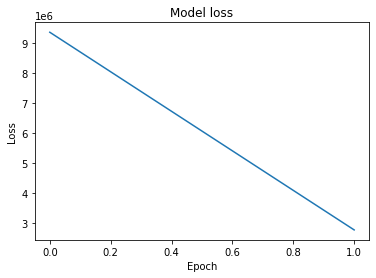

In [ ]:
1# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [ ]:
for epoch in range(5):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('models/model3_'+str(epoch+6))
    
    loss_history.append(np.mean(ae_loss))

  0%|          | 0/2 [00:00<?, ?it/s]WARNING:tensorflow:Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
Epoch 1 | Batch: 256 of 500. Loss AE 2675387.25 | Loss Rev1  684574.50 | Loss Rev2  698964.69 | Loss Rev3  827655.50: 100%|██████████| 2/2 [17:57<00:00, 538.99s/it]
Epoch 2 | Batch: 256 of 500. Loss AE 2085514.00 | Loss Rev1  368702.03 | Loss Rev2  356162.12 | Loss Rev3  646503.88: 100%|██████████| 2/2 [17:25<00:00, 522.58s/it]
Epoch 3 | Batch: 256 of 500. Loss AE 1418293.62 | Loss Rev1  274264.38 | Loss Rev2  260783.75 | Loss Rev3  473854.56: 100%|██████████| 2/2 [17:29<00:00, 524.71s/it]
Epoch 4 | Batch: 256 of 500. Loss AE 1205960.38 | Loss Rev1  220224.88 | Loss Rev2  234143.20 | Loss Rev3  335309.97: 100%|██████████| 2/2 [17:05<00:00, 512.69s/it]
Epoch 5 | Batch: 256 of 500. Loss AE 1145782.25 | Loss Rev1  202607.97 | Loss Rev2  225686.62 | Loss Rev3  268981.34: 100%|██████████| 2/2 [16: